# Simple quantum algorithms


## 1. Deutsch-Jozsa algorithm

Alice wants to determine whether Bob's function $f(x)$ ($0 \leq x \leq 2^n -1$) is constant (always 0 or always 1) or balanced (0 on half of the entries, 1 on the other half).

$f$ is of course unknown to Alice.

The circuit corresponding to this algorithm is the following:

![DJ circuit](https://upload.wikimedia.org/wikipedia/commons/b/b5/Deutsch-Jozsa-algorithm-quantum-circuit.png)


### Deutsch-Jozsa oracle

We first construct the quantum routine $U_f$ corresponding to the oracle:

$$ U_{f}|x\rangle|y\rangle\mapsto|x\rangle|y\oplus f(x)\rangle $$

In [1]:
from qat.lang.AQASM import H, X, CNOT, Program, QRoutine

def dj_oracle(func):
    """ construct quantum routine corresponding
    to Deutsch-Jozsa's oracle for a 2-qubit function f: {0,1}^2 -> {0,1}.
    
    Args:
        func (int):
            if func=0, f is a constant, f(x) = 0 forall x;
            if func=1, f is a constant, f(x) = 1 for all x;
            if func=2, f is balanced. Here, we choose: f(00) = f(11) = 0, and f(01) = f(10) = 1
            
    Returns:
        QRoutine: the quantum routine of DJ algo
        
    Note:
        It would be even better to have implementation where f is specified by its action on input states,
        and oracle circuit is synthesized accordingly
    """
    routine = QRoutine()
    query_reg = routine.new_wires(2)
    anc = routine.new_wires(1)
    
    if func == 0:  
        return routine
    if func == 1:
        routine.apply(X, anc) # if f : constant = 1
        return routine
    # else
    for qb in [0, 1]:
        routine.apply(CNOT, query_reg[qb], anc)
    return routine

### Deutsch-Jozsa program

We now write the full program

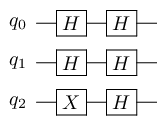

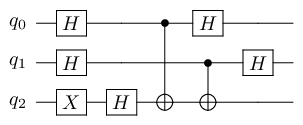

In [2]:
def make_dj_circuit(func, nbshots=0):
    prog = Program()
    query_reg = prog.qalloc(2) # 2 qubits to encode x
    anc = prog.qalloc(1) # ancilla

    X(anc)
    for qb in range(2):
        H(query_reg[qb])
    H(anc)

    prog.apply(dj_oracle(func), query_reg, anc)

    for qb in range(2):
        H(query_reg[qb])

    job = prog.to_circ().to_job(nbshots=nbshots, qubits=query_reg)
    return job

circ = make_dj_circuit(0).circuit
%qatdisplay circ

circ = make_dj_circuit(2).circuit
%qatdisplay circ

We run it for different functions $f$:

In [3]:
from qat.qpus import get_default_qpu
qpu = get_default_qpu()
for func in [0, 1, 2]:
    print("==== func = %s ===="%func)
    job = make_dj_circuit(func)
    res = qpu.submit(job)
    for sample in res:
        print(sample.state, sample.probability)

==== func = 0 ====
|00> 0.9999999999999992
==== func = 1 ====
|00> 0.9999999999999992
==== func = 2 ====
|11> 0.9999999999999992


We can check that for constant functions, we get state $|00\rangle$.

## 2. Bernstein-Vazirani algorithm

Goal: find the bitstring $s$ that appears in definition of function $$f(x) = x \cdot s = \sum_i x_i  s_i \; \mathrm{mod}\, 2 $$ with $x_i$ the bits of the binary representation of $x$.

The circuit corresponding to this algorithm is the following:

![Bernstein Vazirani circuit](https://upload.wikimedia.org/wikipedia/commons/1/15/Bernstein-Vazirani_quantum_circuit.png)

### Oracle

The Bernstein-Vazirani oracle ${U}_f$ is defined as $${U}_f: |x\rangle \rightarrow (-)^{f(x)} |x\rangle.$$

To implement this oracle, we can use the oracle used for Deutsch-Josza, $$ \tilde{U}_f : |x\rangle |y\rangle \rightarrow |x \rangle |y \oplus f(x)\rangle,$$
with $f$ defined as $f(x) = x \cdot s$, and with $|y\rangle = (|0\rangle - |1\rangle)/\sqrt{2}$.


In [4]:
def dot_product(bitstring):
    """Construct quantum routine that does |a>|b> -> |a>|b + a.s mod. 2>
    where a.s is the dot product between a and a bitstring s. The second register 
    is a one-qbit register.
    
    Args:
        bitstring (str): the bitstring s
    Returns:
        QRoutine: the corresponding quantum routine
    """
    qrout = QRoutine()
    a_reg = qrout.new_wires(len(bitstring))
    b_reg = qrout.new_wires(1)
    for pos, bit in enumerate(bitstring):
        if bit == "1":
            qrout.apply(CNOT, a_reg[pos], b_reg)
    return qrout

### Full circuit

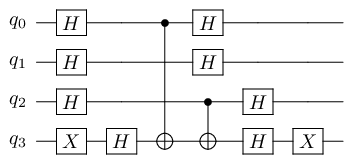

|5> 0.9999999999999987


In [5]:
import qat.lang.AQASM.classarith
from qat.lang.AQASM.arithmetic import mult_const_mod
from qat.lang.AQASM import QInt

hidden_string = "101" # 5
n_data_bits = len(hidden_string)

prog = Program()
reg = prog.qalloc(n_data_bits, class_type=QInt, reverse_bit_order=True)
ancilla = prog.qalloc(1, class_type=QInt, reverse_bit_order=True)

for qb in range(n_data_bits):
    H(reg[qb])
prog.apply(X, ancilla[0])
prog.apply(H, ancilla[0]) # to obtain |0> - |1> on ancilla qubit

prog.apply(dot_product(hidden_string), reg, ancilla)

for qb in range(n_data_bits): # on data qubits only
    H(reg[qb])
    
prog.apply(H, ancilla[0])
prog.apply(X, ancilla[0])
    
circ = prog.to_circ()
%qatdisplay circ
qpu = get_default_qpu()
job = circ.to_job(nbshots=0, qubits=reg)
res = qpu.submit(job)

list_states = []
for sample in res:
    list_states.append((sample.probability, sample.state))
for prob, state in reversed(sorted(list_states,  key=lambda x: x[0])):
    print(state, prob)

### With a noisy QPU

We now execute the circuit on a noisy QPU simulator. To achieve this, we are going to turn our perfect QPU ``qpu`` into a noisy one by simply combining it with a so-called plugin that adds "depolarizing noise" on the circuit:

In [6]:
from depolarizing_plugin import DepolarizingPlugin
depol_plugin = DepolarizingPlugin(prob_1qb=0.005, prob_2qb=0.05)
qpu = get_default_qpu()
noisy_qpu = depol_plugin | qpu

Depolarizing noise, as any noise, is defined by its action on the density matrix $\rho$:

$$\mathcal{E}(\rho) = (1-p) \rho + \frac{p}{3} \left( X \rho X + Y \rho Y + Z \rho Z \right)$$

with $X$, $Y$, and $Z$ the three Pauli matrices, and $p$ the probability that a depolarization event happens. (This is for one-qubit depolarizing noise; a similar expression holds for two-qubit depolarizing noise, with $X$, $Y$ and $Z$ replaced by tensor products of Pauli matrices).

In other words, depolarizing noise leaves the qubit unchanged with probability $1-p$, and otherwise applies a $X$, $Y$ or $Z$ gate with probability $p/3$. $p$ is what is called ``prob_1qb`` above. 

This type of noise is not exactly the type of noise that is observed in actual quantum computers, but it is close enough and it allows to understand the main effects of noise.

Here, the plugin adds depoalizing noise after each gate to mimic an imperfect gate.

- Check that this noise preserves the trace of the density matrix
- What are the corresponding Kraus operators?

We now execute the circuit on this noisy QPU:

In [7]:

job = circ.to_job(nbshots=0, qubits=reg)
res = noisy_qpu.submit(job)

list_states = []
for sample in res:
    list_states.append((sample.probability, sample.state))
for prob, state in reversed(sorted(list_states,  key=lambda x: x[0])):
    print(state, prob)

|5> 0.9079999999999999
|1> 0.03999999999999997
|0> 0.023999999999999973
|4> 0.01799999999999997
|7> 0.008999999999999985
|6> 0.0009999999999999987
|3> 0.0
|2> 0.0


We see that the probability of getting the right answer (5) is no longer 100% because of noise.